In [1]:
# Benchmark Datasets

from benchmark import Benchmark

datasets = Benchmark.load_all_benchmark_datasets()

df = datasets["ecoli"]

In [2]:
# Balanced dataset for sanity checks
from sklearn.datasets import load_iris
import pandas as pd
X, y = load_iris(return_X_y=True, as_frame=True)

# # Deleting one extra class to make dataset binary
# i = y[y==2].index
# X = X.drop(i)
# y = y.drop(i)

# # Formating the df
df = pd.concat([X, y], axis=1)
# df = df.rename(columns={'sepal length (cm)': 0, 'sepal width (cm)': 1, 'petal length (cm)': 2,
#        'petal width (cm)': 3})
df["target"] = df["target"].apply(lambda x: 1 if x != 2 else -1)

In [3]:
# HTRU2 Dataset

# import pandas as pd

# column_names = ["ip_mean", "ip_std", "ip_excess_curtosis", "ip_skewness", "dmsnr_mean", "dmsnr_std", "dmsnr_excess_curtosis", "dmsnr_skewness", "target"]
# df = pd.read_csv("../data/HTRU2/HTRU_2.csv", header=None, names=column_names)


In [4]:
# Describe Dataset

import pandas as pd

def describe_dataset(dataset: pd.DataFrame) -> None:
    print(50*"-")
    print(f"General statistics: \n{df.describe()}")
    print(f"Columns types: \n{df.dtypes}")
    print(f"Number of samples: \n{len(df)}")
    print(f"Classes distribution: \n{df['target'].value_counts()}")
    print(50*"-")

describe_dataset(df)

--------------------------------------------------
General statistics: 
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)      target  
count        150.000000  150.000000  
mean           1.199333    0.333333  
std            0.762238    0.945968  
min            0.100000   -1.000000  
25%            0.300000   -1.000000  
50%            1.300000    1.000000  
75%            1.800000    1.000000  
max            2.500000    1.000000  


In [5]:
# Standardize Dataset

from preprocessing import standardize

df = standardize(df)

describe_dataset(df)

--------------------------------------------------
General statistics: 
                  0             1             2             3      target
count  1.500000e+02  1.500000e+02  1.500000e+02  1.500000e+02  150.000000
mean  -4.736952e-16 -7.815970e-16 -4.263256e-16 -4.736952e-16    0.333333
std    1.003350e+00  1.003350e+00  1.003350e+00  1.003350e+00    0.945968
min   -1.870024e+00 -2.433947e+00 -1.567576e+00 -1.447076e+00   -1.000000
25%   -9.006812e-01 -5.923730e-01 -1.226552e+00 -1.183812e+00   -1.000000
50%   -5.250608e-02 -1.319795e-01  3.364776e-01  1.325097e-01    1.000000
75%    6.745011e-01  5.586108e-01  7.627583e-01  7.906707e-01    1.000000
max    2.492019e+00  3.090775e+00  1.785832e+00  1.712096e+00    1.000000
Columns types: 
0         float64
1         float64
2         float64
3         float64
target      int64
dtype: object
Number of samples: 
150
Classes distribution: 
 1    100
-1     50
Name: target, dtype: int64
------------------------------------------------

In [6]:
import numpy as np
from config import RANDOM_STATE_SEED

# Set our RNG seed for reproducibility.
np.random.seed(RANDOM_STATE_SEED)

# PCA decomposition
from sklearn.decomposition import PCA

X_raw = df.loc[:, df.columns != 'target']#.to_numpy()
y_raw = df['target']#.to_numpy()

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_df = pca.fit_transform(X=X_raw)

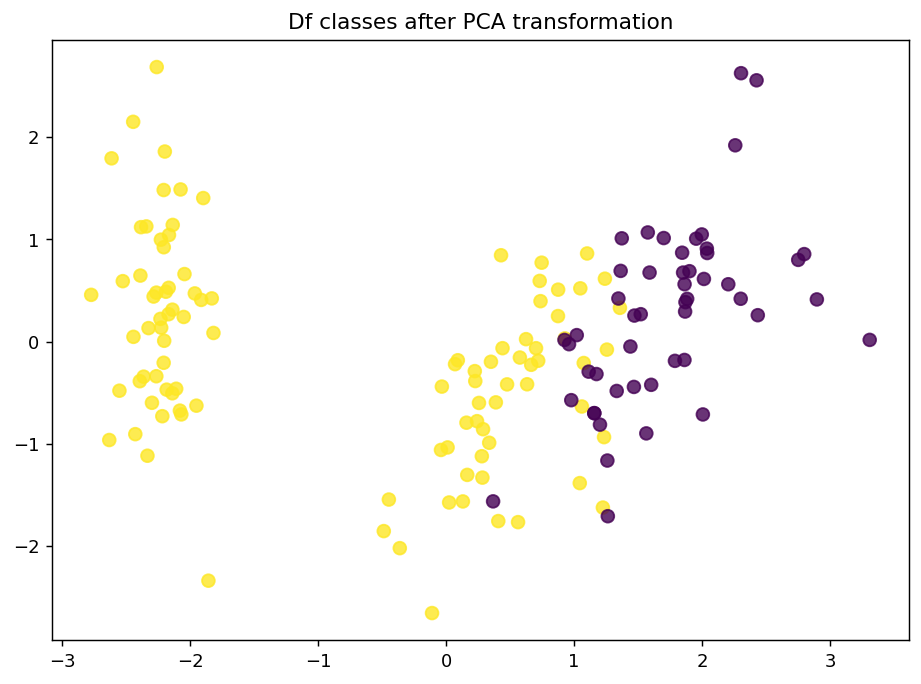

In [7]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = transformed_df[:, 0], transformed_df[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10)
plt.title('Df classes after PCA transformation')
plt.show()

In [8]:
# Dataset spliting
from sklearn.model_selection import train_test_split
from collections import Counter

from config import TEST_SIZE, INITIAL_TRAIN_SIZE

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=TEST_SIZE, random_state=RANDOM_STATE_SEED, shuffle=True, stratify=y_raw)

print("Train dataset:")
print(f"{len(y_train)} samples")
print(f"{Counter(y_train)}")

print("Test dataset:")
print(f"{len(y_test)} samples")
print(f"{Counter(y_test)}")

# Initial train and pool split
X_train_init, X_pool, y_train_init, y_pool = train_test_split(X_train, y_train, train_size=INITIAL_TRAIN_SIZE, random_state=RANDOM_STATE_SEED, shuffle=True, stratify=y_train)

print("Init train dataset:")
print(f"{len(y_train_init)} samples")
print(f"{Counter(y_train_init)}")

print("Pool dataset:")
print(f"{len(y_pool)} samples")
print(f"{Counter(y_pool)}")

Train dataset:
120 samples
Counter({1: 80, -1: 40})
Test dataset:
30 samples
Counter({1: 20, -1: 10})
Init train dataset:
12 samples
Counter({1: 8, -1: 4})
Pool dataset:
108 samples
Counter({1: 72, -1: 36})


## Active Learning

In [9]:
from config import WEIGHTED_TRAINING

# Samples weighting
if WEIGHTED_TRAINING:
    from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
    classes_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_init), y=y_train_init)
    CLASS_WEIGHT = {}
    for c, cw in list(zip(np.unique(y_train_init), classes_weights)):
        CLASS_WEIGHT[c] = cw
    print(CLASS_WEIGHT)

In [10]:
# Hyperparameters tunning of the initial model
from sklearn.base import ClassifierMixin
from sklearn.model_selection._search import BaseSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, StratifiedKFold
from config import PARAMS_GRID, VERBOSE

from metrics import f2_score, pr_auc_score


def tune_classifiers_hyperparameters(Clf: ClassifierMixin, X, y, params_grid, GridSearchMethod: BaseSearchCV,  scorer, weighted_training=False, random_state=13, verbose=True) -> tuple:

    skf = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)
    # Any GridSearch assumes stratified folds if there is classifier
    if issubclass(GridSearchMethod, GridSearchCV):
        gs = GridSearchMethod(estimator=Clf(), param_grid=params_grid, scoring=scorer, refit=True, cv=skf)
    elif issubclass(GridSearchMethod, HalvingGridSearchCV):
        gs = GridSearchMethod(estimator=Clf(), param_grid=params_grid, scoring=scorer, refit=True, cv=skf, factor=2)
    else:
        raise ValueError("Unknown or unsupported BaseSearchCV") 
    
    if weighted_training:
        sample_weight = compute_sample_weight(class_weight=CLASS_WEIGHT, y=y)
    else:
        sample_weight = None
    gs.fit(X, y, sample_weight=sample_weight)

    if verbose:
        params_combinations = gs.cv_results_["params"]
        params_combinations_scores = gs.cv_results_["mean_test_score"]
        for i, params in enumerate(params_combinations):
            print(f"{params}\n{params_combinations_scores[i]}")

    return (gs.best_estimator_, gs.best_params_)

In [11]:
# # 1. Uncertainty sampling
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier

# # Import active learning classes and methods
# import os
# import sys
# # module_path = os.path.abspath(os.path.join('./active_learning/modAL/'))
# # if module_path not in sys.path:
# #     sys.path.append(module_path)

# from modAL.models import ActiveLearner
# from modAL.uncertainty import uncertainty_sampling
# from modAL.random_sampling import random_sampling

# Clf = KNeighborsClassifier
# # init_model, params = tune_classifiers_hyperparameters(Clf, X_train_init, y_train_init, params_grid=PARAMS_GRID[Clf.__name__], GridSearchMethod=GridSearchCV, scorer=f2_score, weighted_training=False, random_state=RANDOM_STATE_SEED, verbose=False)
# # print(f"Optimal hyperparameters: {params}")
# # learner = ActiveLearner(estimator=init_model, query_strategy=uncertainty_sampling)
# # learner.X_training = X_train_init
# # learner.y_training = y_train_init
# learner = ActiveLearner(estimator=Clf(n_neighbors=3), X_training=X_train_init, y_training=y_train_init, query_strategy=random_sampling)

In [12]:
# # 2.1 Query-by-Committee
# from sklearn.svm import SVC
# from modAL.models import ActiveLearner, Committee

# n_members = 3

# Clf = SVC
# init_model, params = tune_classifiers_hyperparameters(Clf, X_train_init, y_train_init, params_grid=PARAMS_GRID[Clf.__name__], GridSearchMethod=GridSearchCV, scorer=f2_score, random_state=RANDOM_STATE_SEED, verbose=False)
# print(f"Optimal hyperparameters: {params}")

# learners = []
# for _ in range(n_members):
#     learner = ActiveLearner(
#             estimator = init_model
#         )
#     learner.X_training = X_train_init
#     learner.y_training = y_train_init
#     learners.append(learner)

# from modAL.disagreement import vote_entropy_sampling

# committee = Committee(
#     learner_list = learners,
#     query_strategy = vote_entropy_sampling
# )

# learner = committee

In [13]:
# # 2.2 Query-by-Bagging
# import numpy as np

# # Set our RNG seed for reproducibility.
# RANDOM_STATE_SEED = 121
# np.random.seed(RANDOM_STATE_SEED)

# n_members = 9
# # from sklearn.ensemble import RandomForestClassifier
# # model = RandomForestClassifier()
# from modAL import ActiveLearner
# from modAL import Committee
# from sklearn.svm import SVC
# Clf = SVC
# init_model, params = tune_classifiers_hyperparameters(Clf, X_train_init, y_train_init, param_grid[Clf.__name__], GridSearchCV, f2_score, verbose=False)
# print(f"Optimal hyperparameters: {params}")

# learners = []
# for _ in range(n_members):
#     learner = ActiveLearner(
#             estimator = init_model,
#             X_training = X_train_init, y_training = y_train_init,
#             bootstrap_init = True,
#             stratify=True
#         )
#     learners.append(learner)

# from modAL.disagreement import max_disagreement_sampling

# committee = Committee(
#     learner_list = learners,
#     query_strategy = max_disagreement_sampling
# )

# learner = committee

# # AFTER RELEARNING WITH ONE ADDITIONAL SAMPLE USE REBAGGING OR BOOTSTRAP ON TEACH!

In [14]:
# 2.3 Query-by-Boosting TODO

In [15]:
# 3. Expected Model Change TODO - probably use bayesian optimization - expected model improvement

In [16]:
# 4. Expected Error Reduction
from sklearn.naive_bayes import GaussianNB
import functools

# Import active learning classes and methods
import os
import sys
module_path = os.path.abspath(os.path.join('./active_learning/modAL/'))
if module_path not in sys.path:
    sys.path.append(module_path)

from modAL.models import ActiveLearner
from modAL.expected_error import expected_error_reduction

# Decorate EER with proper loss function
def expected_error_reduction_with_loss(func, loss_type: str):
    @functools.wraps(func)
    def loss_wrapper(*args, **kwargs):
        return func(*args, loss=loss_type, **kwargs)
    return loss_wrapper

Clf = GaussianNB
EER_LOSS_TYPE = "log"
# Hiperparameters tunning
#_, params = tune_classifiers_hyperparameters(Clf, X_train_init, y_train_init, params_grid=PARAMS_GRID[Clf.__name__], GridSearchMethod=GridSearchCV, scorer=f2_score, weighted_training=WEIGHTED_TRAINING, random_state=RANDOM_STATE_SEED, verbose=VERBOSE)

sample_weight = compute_sample_weight(class_weight=CLASS_WEIGHT, y=y_train_init) if WEIGHTED_TRAINING else None
# Hiperparameters tunning
# learner = ActiveLearner(estimator=Clf(**params), X_training=X_train_init, y_training=y_train_init, query_strategy=expected_error_reduction_with_loss(expected_error_reduction, loss_type=EER_LOSS_TYPE), sample_weight=sample_weight)

# Default hiperparameters
learner = ActiveLearner(estimator=Clf(), X_training=X_train_init, y_training=y_train_init, query_strategy=expected_error_reduction_with_loss(expected_error_reduction, loss_type=EER_LOSS_TYPE), sample_weight=sample_weight)

In [17]:
# print(params) # default 1e-9

In [18]:
# # 5. Variance Reduction
# # from modAL.decorators import change_repr
# from sklearn.base import BaseEstimator 
# from modAL.utils.data import modALinput

# from modAL.utils.selection import (multi_argmin, shuffled_argmin)

# from numpy.linalg import LinAlgError

# # @change_repr
# def fisher_information_sampling(classifier: BaseEstimator, X: modALinput,
#                     n_instances: int = 1, random_tie_break: bool = False,
#                     **uncertainty_measure_kwargs) -> np.ndarray:
#     """
#     Fisher Information sampling query strategy. Selects the instances which influences the sensitivity of the model's likelihood function with respect to the model parameters least.
#     Args:
#         classifier: The classifier for which the labels are to be queried.
#         X: The pool of samples to query from.
#         n_instances: Number of samples to be queried.
#         random_tie_break: If True, shuffles utility scores to randomize the order. This
#             can be used to break the tie when the highest utility score is not unique.
#         **uncertainty_measure_kwargs: Keyword arguments to be passed for the uncertainty
#             measure function.
#     Returns:
#         The indices of the instances from X chosen to be labelled.
#         The margin metric of the chosen instances.
#     """

#     probabilities = classifier.predict_proba(X, **uncertainty_measure_kwargs)
#     W_x = np.diag(np.prod(probabilities, axis=1))
#     I_u = np.linalg.multi_dot([X.T, W_x, X])

#     fi = []
#     for i in range(W_x.shape[0]):
#         I_x = np.outer((X[i]*W_x[i,i]), X[i])
#         try:
#             inv_I_x = np.linalg.inv(I_x)
#         except LinAlgError:
#             inv_I_x = np.linalg.pinv(I_x) # or other options such as: dropping the sample (singularity means low sensitivity of the model to that sample); regularization (adding small positive values to the diagonal of the initial matrix to stabilize the calculations); pseudo-inverse (this situation - it exists for all matrices)
#         tr = np.trace(np.linalg.multi_dot([I_u, inv_I_x]))
#         fi.append(tr)

#     fi = np.array(fi)

#     if not random_tie_break:
#         return multi_argmin(fi, n_instances=n_instances)

#     return shuffled_argmin(fi, n_instances=n_instances)

# from sklearn.linear_model import LogisticRegression
# from modAL.models import ActiveLearner

# logistic_regressor = LogisticRegression(penalty=None, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=RANDOM_STATE_SEED, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
# learner = ActiveLearner(estimator=logistic_regressor, query_strategy=fisher_information_sampling, X_training=X_train_init, y_training=y_train_init)

In [19]:
# 6. Density-weighted methods

In [20]:
from metrics import method_eval, f2_score

VERBOSE = 1

# Evaluate model trained on the whole data
# model = SVC(**params)
# model = LogisticRegression(penalty=None, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=RANDOM_STATE_SEED, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
# model = LogisticRegression()
# model = RandomForestClassifier()
#model = Clf(**params)
model = Clf()

sample_weight = compute_sample_weight(class_weight=CLASS_WEIGHT, y=y_train) if WEIGHTED_TRAINING else None

model.fit(X_train, y_train, sample_weight=sample_weight)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

print("Full dataset model")
print(50*'-')
full_model_score = method_eval(y_test=y_test, y_pred=y_pred, y_proba=y_proba, verbose=VERBOSE)
print(50*'-')

# Evaluate initial model
y_pred = learner.predict(X_test)
y_proba = learner.predict_proba(X_test)

print("Initial model")
print(50*'-')
unqueried_score = method_eval(y_test=y_test, y_pred=y_pred, y_proba=y_proba, verbose=VERBOSE)
print(50*'-')

Full dataset model
--------------------------------------------------
accuracy: 0.8333333333333334,
precision: 0.9411764705882353,
recall: 0.8,
f2_score: 0.8247422680412373,
auc_pr_curve: 0.9651345125023867,
auc_roc_curve: 0.925
--------------------------------------------------
Initial model
--------------------------------------------------
accuracy: 0.7333333333333333,
precision: 0.7307692307692307,
recall: 0.95,
f2_score: 0.8962264150943396,
auc_pr_curve: 0.9100685669542514,
auc_roc_curve: 0.8300000000000001
--------------------------------------------------


In [21]:
if len(full_model_score) == 2:
    full_model_score = list(full_model_score["metrics"].values())
for x in full_model_score:
    print(f"{x:.4f} & ", end="")

print("\n")

for x in unqueried_score["metrics"].values():
    print(f"{x:.4f} & ", end="")

0.8333 & 0.9412 & 0.8000 & 0.8247 & 0.9651 & 0.9250 & 

0.7333 & 0.7308 & 0.9500 & 0.8962 & 0.9101 & 0.8300 & 

In [22]:
# Metrics for tracking active learning process
CHANGE_WINDOW_SIZE = 10
MEAN_ABS_DIFF_THRESHOLD = 0.05

def calculate_mean_abs_difference(X, Y):
    return np.mean(np.abs(X-Y))

In [23]:
import warnings
from config import StoppingCriterion, BatchMode, AL_N_QUERIES, AL_QUERY_FIXED_BATCH_SIZE, AL_FRACTION_OF_TRAIN_QUERIES, AL_QUERY_FRACTION_OF_TRAIN_BATCH_SIZE
def perpare_queries_and_batch_size(stopping_criterion: StoppingCriterion, batch_mode: BatchMode, pool_size: int, init_train_size: int) -> tuple:
    match stopping_criterion.name:
        case "N_QUERIES":
            n_queries = AL_N_QUERIES
            match batch_mode.name:
                case 'FIXED_BATCH_SIZE':
                    batch_size = AL_QUERY_FIXED_BATCH_SIZE
                    if n_queries * batch_size > pool_size:
                        warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")
                        n_queries = int(n_queries/batch_size)
                case 'FRACTION_OF_N_QUERIES':
                    raise NotImplemented(f"{batch_mode.name} for {stopping_criterion.name} not implemented.") # TODO?
                case 'FRACTION_OF_TRAIN_SIZE':
                    raise NotImplemented(f"{batch_mode.name} for {stopping_criterion.name} not implemented.") # TODO?
        case "FRACTION_OF_TRAIN_QUERIES":
            n_queries = int((AL_FRACTION_OF_TRAIN_QUERIES * pool_size / 0.9) - init_train_size)
            match batch_mode.name:
                case 'FIXED_BATCH_SIZE':
                    batch_size = AL_QUERY_FIXED_BATCH_SIZE
                    if n_queries * batch_size > pool_size:
                        warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")
                        n_queries = int(n_queries/batch_size)
                case 'FRACTION_OF_N_QUERIES':
                    raise NotImplemented(f"{batch_mode.name} for {stopping_criterion.name} not implemented.")
                case 'FRACTION_OF_TRAIN_SIZE':
                    batch_size = int(AL_QUERY_FRACTION_OF_TRAIN_BATCH_SIZE * pool_size / 0.9)
                    if n_queries * batch_size > pool_size:
                        warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")
                        n_queries = int(n_queries/batch_size)
        # TODO: Add debuging of number of queries

        case "ENTROPY_CONFIDENCE":
            n_queries = X_pool.shape[0]
            batch_size = AL_QUERY_FIXED_BATCH_SIZE
            if n_queries * batch_size > pool_size:
                        n_queries = int(n_queries/batch_size)
                        warnings.warn(f"Warning: The pool samples size ({pool_size}) is to small for requested number of queries ({n_queries * batch_size}). Decreasing n_queries to match pool_size.")
            n_decline_rounds = 0

    return n_queries, batch_size

In [24]:
##############################
# Pool based random sampling #
##############################
import warnings, copy
from modAL.random_sampling import random_sampling
from modAL.uncertainty import classifier_entropy
from modAL.utils.data import data_vstack

warnings.simplefilter(action='ignore', category=FutureWarning)

learner_al = ActiveLearner(estimator=Clf(), X_training=X_train_init, y_training=y_train_init, query_strategy=random_sampling)
X_pool_al, y_pool_al = copy.deepcopy(X_pool), copy.deepcopy(y_pool)

from config import StoppingCriterion, BatchMode
stopping_criterion  = StoppingCriterion.FRACTION_OF_TRAIN_QUERIES
batch_mode = BatchMode.FIXED_BATCH_SIZE
n_queries, batch_size = perpare_queries_and_batch_size(stopping_criterion, batch_mode, len(y_pool_al), len(learner_al.y_training))

rs_performance_history = [unqueried_score["metrics"]]
initial_confidence = np.mean(classifier_entropy(learner_al, X_test))
rs_entropy_confidence_history = [initial_confidence]

for index in range(n_queries):
    query_index, query_instance = learner_al.query(X_pool_al.to_numpy(), n_instances=batch_size)

    if VERBOSE:
        # To track which samples are choosen. It is usefull, when comparing different algorithms.
        global_query_index = X_pool_al.iloc[query_index].index

        print(f"\n{index+1}. iteration: \nChosen sample was of an index: {global_query_index[-1]}\nChosen sample was of a class: {y_pool_al.iloc[query_index]}\n")

    # Teach our ActiveLearner model the record it has requested.
    X, y = X_pool_al.iloc[query_index], y_pool_al.iloc[query_index]
    if WEIGHTED_TRAINING:
        new_y = data_vstack((learner_al.y_training, y))
        sample_weight = compute_sample_weight(class_weight=CLASS_WEIGHT, y=new_y)
    else:
        sample_weight = None
    learner_al.teach(X=X.to_numpy(), y=y.to_numpy(), sample_weight=sample_weight) # implicitly it gets fit_kwargs -> sample_weight
    # learner_al.teach(X=X, y=y, sample_weight=sample_weight, bootstrap=True, stratify=True) # for Query-By-Bagging


    # Remove the queried instance from the unlabeled pool.
    X_pool_al, y_pool_al = X_pool_al.drop(global_query_index), y_pool_al.drop(global_query_index)

    # Calculate and report our model's accuracy.
    y_pred = learner_al.predict(X_test)
    y_proba = learner_al.predict_proba(X_test)
    print(50*'-')
    model_evaluation = method_eval(y_test=y_test, y_pred=y_pred, y_proba=y_proba, verbose=VERBOSE)
    print(50*'-')

    # Save our model's performance for plotting.
    rs_performance_history.append(model_evaluation["metrics"])

    


1. iteration: 
Chosen sample was of an index: 59
Chosen sample was of a class: 59    1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.7333333333333333,
precision: 0.7307692307692307,
recall: 0.95,
f2_score: 0.8962264150943396,
auc_pr_curve: 0.9100685669542514,
auc_roc_curve: 0.8300000000000001
--------------------------------------------------

2. iteration: 
Chosen sample was of an index: 53
Chosen sample was of a class: 53    1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.7333333333333333,
precision: 0.7307692307692307,
recall: 0.95,
f2_score: 0.8962264150943396,
auc_pr_curve: 0.9100685669542514,
auc_roc_curve: 0.8300000000000001
--------------------------------------------------

3. iteration: 
Chosen sample was of an index: 96
Chosen sample was of a class: 96    1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.7333333333333333,
precision: 0.73076923

--------------------------------------------------
accuracy: 0.7666666666666667,
precision: 0.7407407407407407,
recall: 1.0,
f2_score: 0.9345794392523363,
auc_pr_curve: 0.9100685669542514,
auc_roc_curve: 0.8300000000000001
--------------------------------------------------

10. iteration: 
Chosen sample was of an index: 132
Chosen sample was of a class: 132   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.7666666666666667,
precision: 0.7407407407407407,
recall: 1.0,
f2_score: 0.9345794392523363,
auc_pr_curve: 0.9100685669542514,
auc_roc_curve: 0.8300000000000001
--------------------------------------------------

11. iteration: 
Chosen sample was of an index: 108
Chosen sample was of a class: 108   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.7666666666666667,
precision: 0.7407407407407407,
recall: 1.0,
f2_score: 0.9345794392523363,
auc_pr_curve: 0.9100685669542514,
auc_roc_curve: 0.83000000

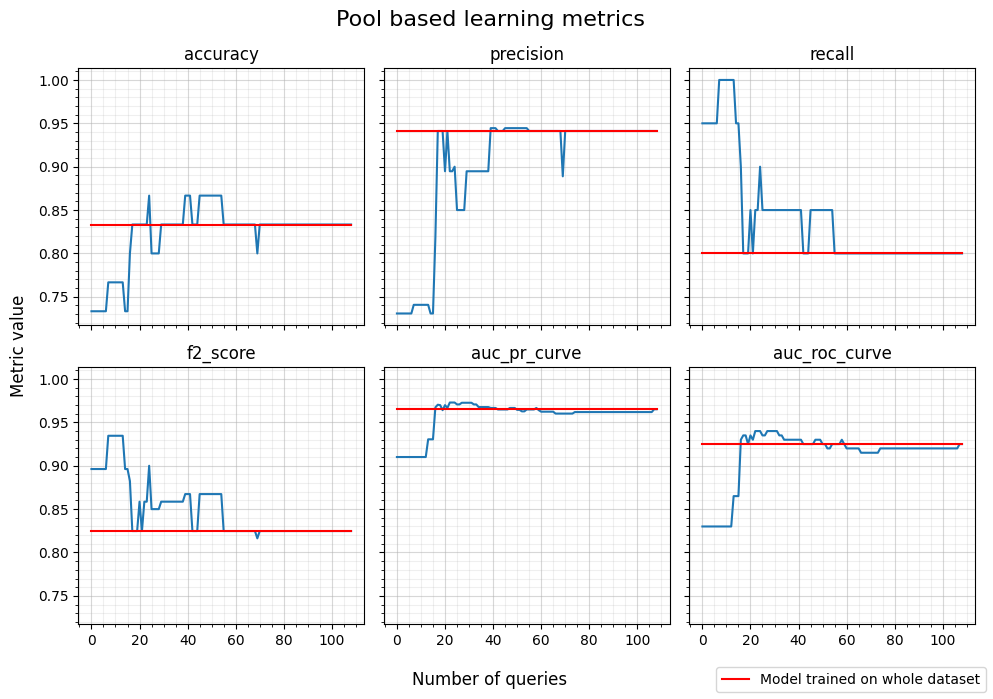

In [25]:
import matplotlib.pyplot as plt

# Plotting metrics
fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex=True, sharey=True)

if len(full_model_score) == 2:
    full_model_score = list(full_model_score["metrics"].values())
rs_metrics = list(zip(*[x.values() for x in rs_performance_history]))

n = len(rs_performance_history)

# major_xticks = np.round(np.linspace(0, n, 10)).astype(int)
# minor_xticks = np.round(np.linspace(0, n, 20)).astype(int)

# major_xticks = np.arange(0, n +10, 10)
# minor_xticks = np.arange(0, n +1, 1)

# major_yticks = np.arange(0.5, 1 +0.1, 0.1)
# minor_yticks = np.arange(0.5, 1 +0.05, 0.05)

for i, metric_name in enumerate(rs_performance_history[0].keys()):
    ax = axs[int(i/3), int(i%3)]
    ax.plot(range(len(rs_metrics[i])), rs_metrics[i])
    # ax.set_xticks(major_xticks)
    # ax.set_xticks(minor_xticks, minor=True)
    # ax.set_xticklabels(labels=major_xticks, rotation=90, ha='right')
    # ax.set_yticks(major_yticks)
    # ax.set_yticks(minor_yticks, minor=True)
    ax.minorticks_on()
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    handle = ax.plot(range(len(rs_metrics[i])), np.ones(len(rs_metrics[i]))*full_model_score[i], "r")
    ax.set_title(metric_name)

# TODO: point, for fraction of training dataset, which is efficient to obtain good model. 0,4?
# Check it for different datasets and with cross validation

fig.suptitle("Pool based learning metrics", fontsize=16)
fig.supxlabel("Number of queries")
fig.supylabel("Metric value")
fig.legend(handle, ["Model trained on whole dataset"], loc='lower right')
fig.tight_layout()

In [26]:
##############################
# Pool based active learning #
##############################
from modAL.uncertainty import classifier_entropy
from modAL.utils.data import data_vstack
import copy, time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

learner_al = copy.deepcopy(learner)
X_pool_al, y_pool_al = copy.deepcopy(X_pool), copy.deepcopy(y_pool)

from config import StoppingCriterion, BatchMode, AL_N_DECLINE_ROUNDS
stopping_criterion  = StoppingCriterion.FRACTION_OF_TRAIN_QUERIES
batch_mode = BatchMode.FIXED_BATCH_SIZE
n_queries, batch_size = perpare_queries_and_batch_size(stopping_criterion, batch_mode, len(y_pool_al), len(learner.y_training))

# Those are sanity checks, so they are supposed to be used for code assumptions, not for user inputs checks
# assert solver == "liblinear", ("message")

# AL statistics
al_queried_classes_counter = Counter()
al_performance_history = [unqueried_score["metrics"]]
iterations_time_history = []
initial_confidence = np.mean(classifier_entropy(learner_al, X_test))
al_entropy_confidence_history = [initial_confidence]

# AL loop
for index in range(n_queries):

  start = time.perf_counter()
  query_index, query_instance = learner_al.query(X_pool_al.to_numpy(), n_instances=batch_size)

  # To track which samples are choosen. It is usefull, when comparing different algorithms.
  global_query_index = X_pool_al.iloc[query_index].index

  print(f"\n{index+1}. iteration: \nChosen sample was of an index: {global_query_index[-1]}\nChosen sample was of a class: {y_pool_al.iloc[query_index]}\n")
  al_queried_classes_counter.update(y_pool_al.iloc[query_index])

  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool_al.iloc[query_index], y_pool_al.iloc[query_index]
  if WEIGHTED_TRAINING:
    new_y = data_vstack((learner_al.y_training, y))
    sample_weight = compute_sample_weight(class_weight=CLASS_WEIGHT, y=new_y)
  else:
    sample_weight = None
  learner_al.teach(X=X.to_numpy(), y=y.to_numpy(), sample_weight=sample_weight) # implicitly it gets fit_kwargs -> sample_weight
  # learner_al.teach(X=X, y=y, sample_weight=sample_weight, bootstrap=True, stratify=True) # for Query-By-Bagging


  # Remove the queried instance from the unlabeled pool.
  X_pool_al, y_pool_al = X_pool_al.drop(global_query_index), y_pool_al.drop(global_query_index)

  # Calculate and report our model's accuracy.
  y_pred = learner_al.predict(X_test)
  y_proba = learner_al.predict_proba(X_test)
  print(50*'-')
  model_evaluation = method_eval(y_test=y_test, y_pred=y_pred, y_proba=y_proba, verbose=VERBOSE)
  print(50*'-')

  # Save our model's performance for plotting.
  al_performance_history.append(model_evaluation["metrics"])

  # Check al process change
  # if index + 2 > CHANGE_WINDOW_SIZE:
  #   metrics = list(zip(*[x.values() for x in performance_history]))    
  #   a = metrics[0][-(CHANGE_WINDOW_SIZE+1):-1]
  #   b = metrics[0][-CHANGE_WINDOW_SIZE:]
  #   print(a,b)
  #   mean_abs_diff = calculate_mean_abs_difference(np.array(b), np.array(a))
  #   if mean_abs_diff < MEAN_ABS_DIFF_THRESHOLD:
  #     print("WARNING: Model is not improving!")

  # Entropy confidence
  al_entropy_confidence_history.append(np.mean(classifier_entropy(learner_al, X_test)))
  if stopping_criterion == "ENTROPY_CONFIDENCE":
    if al_entropy_confidence_history[-1] < al_entropy_confidence_history[-2]:
      n_decline_rounds += 1
    else:
      n_decline_rounds = 0
    if n_decline_rounds >= AL_N_DECLINE_ROUNDS:
      break
    if len(y_pool_al) < batch_size:
      break
  
  elapsed = time.perf_counter() - start
  iterations_time_history.append(elapsed)
    
print(f"Queried samples:\n {al_queried_classes_counter}")
n_queries = sum(al_queried_classes_counter.values())
print(f"{len(y_train_init) + index+1} out of {len(y_train)} samples seen.")
print(f"Average iteration time was {np.mean(iterations_time_history):0.2f}s")


1. iteration: 
Chosen sample was of an index: 132
Chosen sample was of a class: 132   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.7666666666666667,
precision: 0.7407407407407407,
recall: 1.0,
f2_score: 0.9345794392523363,
auc_pr_curve: 0.9100685669542514,
auc_roc_curve: 0.8300000000000001
--------------------------------------------------

2. iteration: 
Chosen sample was of an index: 104
Chosen sample was of a class: 104   -1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.7333333333333333,
precision: 0.7307692307692307,
recall: 0.95,
f2_score: 0.8962264150943396,
auc_pr_curve: 0.9055907056342849,
auc_roc_curve: 0.8200000000000001
--------------------------------------------------

3. iteration: 
Chosen sample was of an index: 76
Chosen sample was of a class: 76    1
Name: target, dtype: int64

--------------------------------------------------
accuracy: 0.7666666666666667,
precision: 0.74074

In [27]:
for x in al_performance_history[-1].values():
    print(f"{x:.4f} & ", end="")

0.8333 & 0.9412 & 0.8000 & 0.8247 & 0.9651 & 0.9250 & 

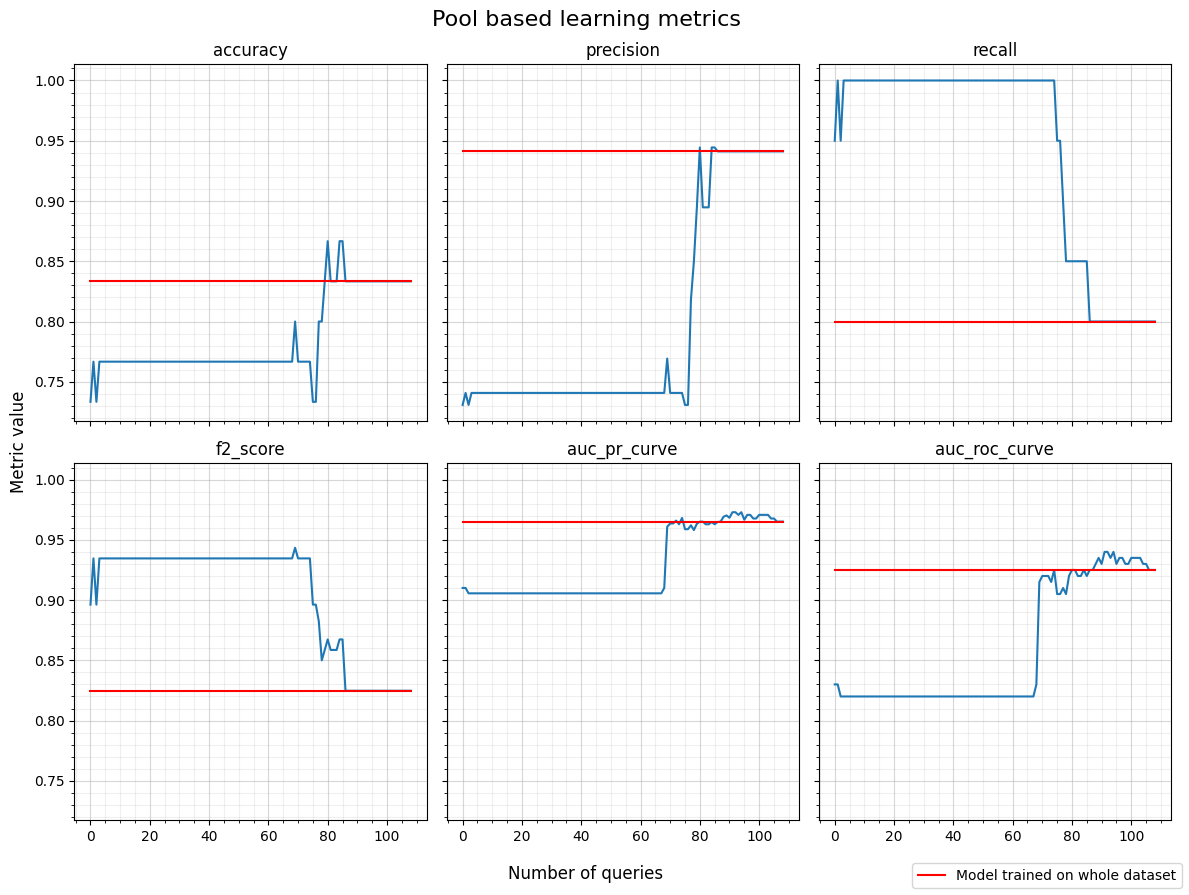

In [28]:
import matplotlib.pyplot as plt

# Plotting metrics
fig, axs = plt.subplots(2, 3, figsize=(12, 9), sharex=True, sharey=True)

if len(full_model_score) == 2:
    full_model_score = list(full_model_score["metrics"].values())
al_metrics = list(zip(*[x.values() for x in al_performance_history]))

n = len(al_performance_history)

# major_xticks = np.round(np.linspace(0, n, 10)).astype(int)
# minor_xticks = np.round(np.linspace(0, n, 20)).astype(int)

# major_xticks = np.arange(0, n +10, 10)
# minor_xticks = np.arange(0, n +1, 1)

# major_yticks = np.arange(0.5, 1 +0.1, 0.1)
# minor_yticks = np.arange(0.5, 1 +0.05, 0.05)

for i, metric_name in enumerate(al_performance_history[0].keys()):
    ax = axs[int(i/3), int(i%3)]
    ax.plot(range(len(al_metrics[i])), al_metrics[i])
    # ax.set_xticks(major_xticks)
    # ax.set_xticks(minor_xticks, minor=True)
    # ax.set_xticklabels(labels=major_xticks, rotation=90, ha='right')
    # ax.set_yticks(major_yticks)
    # ax.set_yticks(minor_yticks, minor=True)
    ax.minorticks_on()
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    handle = ax.plot(range(len(al_metrics[i])), np.ones(len(al_metrics[i]))*full_model_score[i], "r")
    ax.set_title(metric_name)

# TODO: point, for fraction of training dataset, which is efficient to obtain good model. 0,4?

fig.suptitle("Pool based learning metrics", fontsize=16)
fig.supxlabel("Number of queries")
fig.supylabel("Metric value")
fig.legend(handle, ["Model trained on whole dataset"], loc='lower right')
fig.tight_layout()

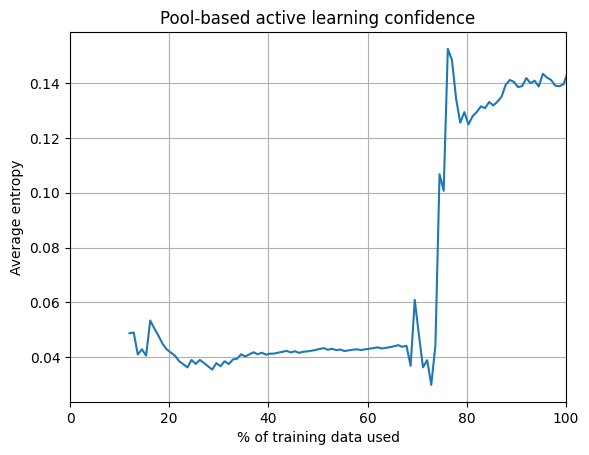

In [29]:
from config import AL_QUERY_FIXED_BATCH_SIZE
# Plot the confidence
x_train_usage = [i*AL_QUERY_FIXED_BATCH_SIZE/len(y_train)*100+len(y_train_init) for i in range(len(al_entropy_confidence_history))]
plt.plot(x_train_usage, al_entropy_confidence_history)
plt.title("Pool-based active learning confidence")
plt.xlabel(r'% of training data used')
plt.ylabel('Average entropy')
plt.xlim(left=0, right=100)
plt.grid()
plt.show()

In [30]:
al_performance_history[0].keys()

dict_keys(['accuracy', 'precision', 'recall', 'f2_score', 'auc_pr_curve', 'auc_roc_curve'])

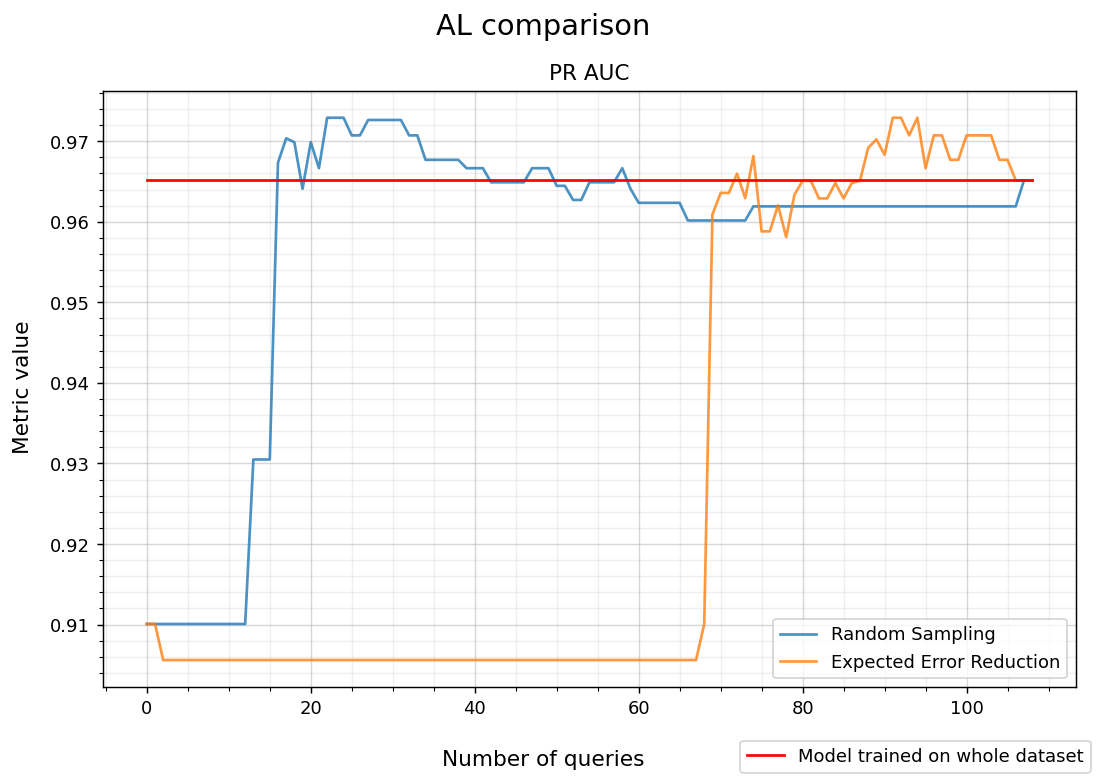

In [31]:
# Comparison of RS, US, and EER

i = 4 # PR AUC
# for metric_name in al_performance_history[0].keys()[0]: # for all keys should be
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.plot(range(len(rs_metrics[i])), rs_metrics[i], label='Random Sampling',   alpha=8/10)
ax.plot(range(len(al_metrics[i])), al_metrics[i], label='Expected Error Reduction', alpha=8/10)
ax.minorticks_on()
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
handle = ax.plot(range(len(al_metrics[i])), np.ones(len(al_metrics[i]))*full_model_score[i], "r")
ax.set_title("PR AUC")
ax.legend(loc='lower right')

fig.suptitle("AL comparison", fontsize=16)
fig.supxlabel("Number of queries")
fig.supylabel("Metric value")
fig.legend(handle, ["Model trained on whole dataset"], loc='lower right')
fig.tight_layout()

NameError: name 'N_QUERIES' is not defined

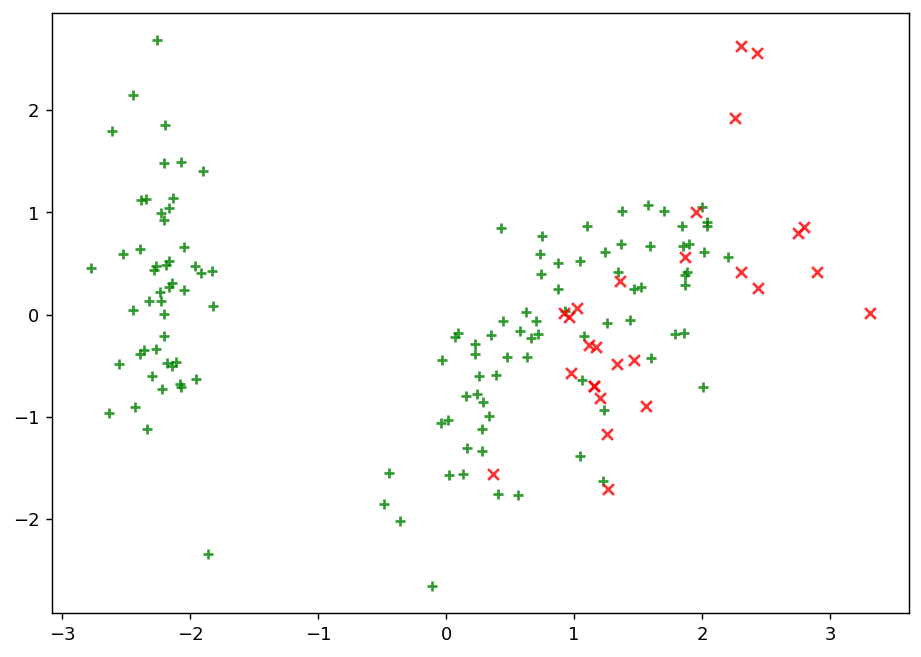

In [32]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title(f'Classification after {N_QUERIES} queries:')
ax.legend(loc='lower right')

plt.show()

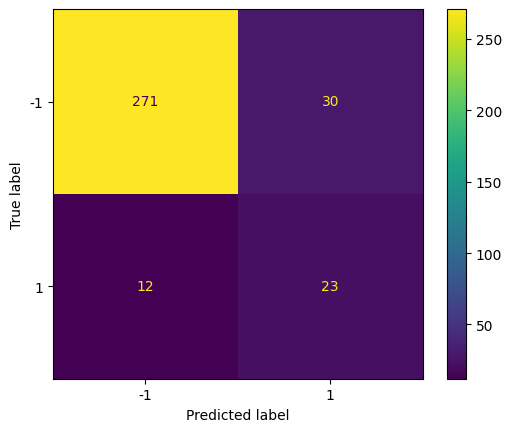

Counter({-1: 283, 1: 53})


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from modAL import Committee

if not issubclass(learner.__class__, Committee):
    classes = learner.estimator.classes_
else:
    classes = learner.classes_

cm = confusion_matrix(y_raw, predictions, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

disp.plot()
plt.show()

print(f"{Counter(predictions)}")

In [ ]:
# For HTRU2

# Final model analysis
# To get different predictions based on the probability threshold, you can set manually probability threshold for model by y_pred = (clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool) # set threshold as 0.3 (to verify??!)
# https://stackoverflow.com/questions/19984957/scikit-learn-predict-default-threshold

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

BEGIN_YEAR = 1990
END_YEAR = 2011

df1 = pd.DataFrame({"year": np.arange(start=BEGIN_YEAR, stop=END_YEAR, step=1), "value": np.random.rand(END_YEAR-BEGIN_YEAR)*100})
df2 = pd.DataFrame({"year": np.arange(start=BEGIN_YEAR, stop=END_YEAR, step=1), "value": np.random.rand(END_YEAR-BEGIN_YEAR)*100})


# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=df1["year"], y=df1["value"],
                    mode='lines+markers',
                    name='Canada'))
fig.add_trace(go.Scatter(x=df2["year"], y=df2["value"],
                    mode='lines',
                    name='America'))

fig.add_vline(x=2005, annotation_text="threshold", annotation_position="bottom right")

fig.update_layout(title='Random percentage',
                   xaxis_title='Year',
                   yaxis_title='Percentage value [%]',
                   yaxis_range=[0,200])

fig.show()

fig.write_html("interactive_html.html")

In [ ]:
import plotly.subplots as subplots
fig = subplots.make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=[1, 2, 3], y=[4, 5, 6]),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=[20, 30, 40], y=[50, 60, 70]),
    row=1, col=2
)

fig.update_layout(height=600, width=800, title_text="Side By Side Subplots")
fig.show()